# ModelTime Resample Py - Complete Cookbook

A comprehensive guide to time series cross-validation, model evaluation, and advanced visualization.

## Table of Contents

1. [Setup and Installation](#setup)
2. [Creating Sample Time Series Data](#data-creation)
3. [Basic Time Series Splitting](#basic-splitting)
4. [Time Series Cross-Validation](#cross-validation)
5. [Model Fitting and Evaluation](#model-fitting)
6. [Accuracy Metrics and Analysis](#accuracy-metrics)
7. [Visualization and Plotting](#visualization)
8. [Convenience Functions](#convenience-functions)
9. [Advanced Visualization](#advanced-visualization)
10. [Interactive Dashboards](#interactive-dashboards)
11. [Real-World Examples](#real-world-examples)
12. [Best Practices](#best-practices)

## 1. Setup and Installation {#setup}

First, let's import all necessary libraries and set up our environment.

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from datetime import datetime, timedelta

# Machine learning models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Import modeltime_resample_py functions
import modeltime_resample_py
from modeltime_resample_py import (
    # Core functions
    time_series_split,
    time_series_cv,
    fit_resamples,
    resample_accuracy,
    
    # Plotting
    plot_resamples,
    plot_time_series_cv_plan,
    
    # Convenience functions
    evaluate_model,
    compare_models
)

# Try advanced visualization
try:
    from modeltime_resample_py import (
        create_interactive_dashboard,
        plot_model_comparison_matrix,
        create_comparison_report
    )
    ADVANCED_VIZ_AVAILABLE = True
except ImportError:
    ADVANCED_VIZ_AVAILABLE = False

# Try convenience function
try:
    from modeltime_resample_py.convenience import quick_cv_split
    QUICK_CV_AVAILABLE = True
except ImportError:
    QUICK_CV_AVAILABLE = False

# Configure plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
warnings.filterwarnings('ignore')

print(f"📦 ModelTime Resample Py Cookbook - Version: {modeltime_resample_py.__version__}")
print(f"✅ Advanced visualization: {ADVANCED_VIZ_AVAILABLE}")
print(f"✅ Quick CV split: {QUICK_CV_AVAILABLE}")
print("🚀 All imports successful!")

📦 ModelTime Resample Py Cookbook - Version: 0.2.0
✅ Advanced visualization: True
✅ Quick CV split: True
🚀 All imports successful!


## 2. Creating Sample Time Series Data {#data-creation}

Let's create various types of realistic time series data for our examples.

In [2]:
def create_sample_time_series(
    start_date='2020-01-01',
    periods=365,
    freq='D',
    trend=0.02,
    seasonality_amplitude=10,
    noise_level=2,
    base_value=100
):
    """Create realistic time series data with trend, seasonality, and noise."""
    dates = pd.date_range(start=start_date, periods=periods, freq=freq)
    t = np.arange(periods)
    
    # Components
    trend_component = base_value + trend * t
    seasonal_component = seasonality_amplitude * np.sin(2 * np.pi * t / 365)
    noise_component = np.random.normal(0, noise_level, periods)
    
    # Combine components
    values = trend_component + seasonal_component + noise_component
    
    return pd.Series(values, index=dates, name='value')

def create_multivariate_data(
    start_date='2020-01-01',
    periods=365,
    freq='D'
):
    """Create multivariate time series data with features."""
    dates = pd.date_range(start=start_date, periods=periods, freq=freq)
    t = np.arange(periods)
    
    # Create features
    data = {
        'date': dates,
        'temperature': 20 + 10 * np.sin(2 * np.pi * t / 365) + np.random.normal(0, 2, periods),
        'humidity': 50 + 20 * np.sin(2 * np.pi * t / 365 + np.pi) + np.random.normal(0, 5, periods),
        'day_of_week': dates.dayofweek,
        'month': dates.month,
        'is_weekend': (dates.dayofweek >= 5).astype(int),
    }
    
    # Create target variable
    target = (
        100 +  # base
        0.5 * data['temperature'] +
        -0.2 * data['humidity'] +
        -5 * data['is_weekend'] +
        10 * np.sin(2 * np.pi * t / 365) +
        np.random.normal(0, 3, periods)
    )
    
    data['sales'] = target
    
    # Add lag features
    df = pd.DataFrame(data)
    df['lag_1'] = df['sales'].shift(1)
    df['lag_7'] = df['sales'].shift(7)
    df['rolling_mean_7'] = df['sales'].rolling(7).mean()
    
    # Drop NaN values
    df = df.dropna().reset_index(drop=True)
    
    return df

# Create datasets
print("Creating sample datasets...")

# Simple univariate time series
ts_simple = create_sample_time_series(periods=500)

# Multivariate time series
df_multivariate = create_multivariate_data(periods=500)

print(f"✅ Created datasets:")
print(f"   - Simple univariate: {len(ts_simple)} observations")
print(f"   - Multivariate: {len(df_multivariate)} observations with {len(df_multivariate.columns)-1} features")

# Display sample data
print("\n📊 Sample Data Preview:")
print("\nSimple Time Series (first 5 rows):")
print(ts_simple.head())

print("\nMultivariate DataFrame (first 5 rows):")
print(df_multivariate.head())

Creating sample datasets...
✅ Created datasets:
   - Simple univariate: 500 observations
   - Multivariate: 493 observations with 9 features

📊 Sample Data Preview:

Simple Time Series (first 5 rows):
2020-01-01    98.671480
2020-01-02    98.102431
2020-01-03    97.596568
2020-01-04    99.583689
2020-01-05    99.501583
Freq: D, Name: value, dtype: float64

Multivariate DataFrame (first 5 rows):
        date  temperature   humidity  day_of_week  month  is_weekend  \
0 2020-01-08    20.443411  44.900561            2      1           0   
1 2020-01-09    20.405179  45.752405            3      1           0   
2 2020-01-10    24.953166  54.618078            4      1           0   
3 2020-01-11    20.352539  45.386467            5      1           1   
4 2020-01-12    21.764330  40.871795            6      1           1   

        sales       lag_1       lag_7  rolling_mean_7  
0  103.435941  101.236387  102.184778       99.217698  
1   96.925424  103.435941  103.994133       98.207882  
2

## 3. Basic Time Series Splitting {#basic-splitting}

The new `time_series_split` function creates single train/test/forecast splits.

In [3]:
print("🔄 Demonstrating time_series_split() with NEW signature")
print("=" * 55)

# Example 1: Date-based splitting
print("\n1️⃣ Date-based splitting with DataFrame:")
X_train, X_test, y_train, y_test, X_forecast, y_forecast = time_series_split(
    data=df_multivariate,
    train_start='2020-01-01',
    train_end='2020-09-30',
    test_start='2020-10-01',
    test_end='2020-12-31',
    date_col='date',
    X_vars=['temperature', 'humidity', 'day_of_week', 'month', 'is_weekend'],
    y_var='sales'
)

print(f"   Training set: {len(X_train)} observations")
print(f"   Test set: {len(X_test)} observations")
print(f"   Features: {list(X_train.columns)}")
print(f"   Target: {list(y_train.columns)}")

# Example 2: Integer-based splitting
print("\n2️⃣ Integer-based splitting:")
X_train_int, X_test_int, y_train_int, y_test_int, _, _ = time_series_split(
    data=df_multivariate,
    train_end=300,
    test_start=301,
    test_end=400,
    date_col='date',
    X_vars=['temperature', 'humidity', 'is_weekend'],
    y_var='sales'
)

print(f"   Integer-based split: train={len(X_train_int)}, test={len(X_test_int)}")
print(f"   Features used: {list(X_train_int.columns)}")

print("\n✅ time_series_split() examples completed!")

🔄 Demonstrating time_series_split() with NEW signature

1️⃣ Date-based splitting with DataFrame:
   Training set: 267 observations
   Test set: 92 observations
   Features: ['temperature', 'humidity', 'day_of_week', 'month', 'is_weekend']
   Target: ['sales']

2️⃣ Integer-based splitting:
   Integer-based split: train=302, test=101
   Features used: ['temperature', 'humidity', 'is_weekend']

✅ time_series_split() examples completed!


## 4. Time Series Cross-Validation {#cross-validation}

The `time_series_cv` function creates multiple CV folds using rolling or expanding windows.

In [4]:
print("🔄 Demonstrating time_series_cv()")
print("=" * 35)

# Example 1: Rolling window cross-validation
print("\n1️⃣ Rolling window cross-validation:")
cv_splits_rolling = time_series_cv(
    data=ts_simple,
    initial='1 year',
    assess='3 months',
    skip='2 months',
    cumulative=False,
    slice_limit=4
)

print(f"   Created {len(cv_splits_rolling)} CV folds")
for i, (train_idx, test_idx) in enumerate(cv_splits_rolling):
    train_dates = ts_simple.index[train_idx]
    test_dates = ts_simple.index[test_idx]
    print(f"   Fold {i+1}: Train ({len(train_idx):3d}): {train_dates[0].date()} to {train_dates[-1].date()}")
    print(f"          Test  ({len(test_idx):3d}): {test_dates[0].date()} to {test_dates[-1].date()}")

# Example 2: CV with DataFrame
print("\n2️⃣ Cross-validation with DataFrame:")
cv_splits_df = time_series_cv(
    data=df_multivariate,
    initial=200,
    assess=50,
    skip=25,
    cumulative=False,
    slice_limit=3,
    date_column='date'
)

print(f"   Created {len(cv_splits_df)} CV folds for multivariate data")
for i, (train_idx, test_idx) in enumerate(cv_splits_df):
    print(f"   Fold {i+1}: Train={len(train_idx):3d}, Test={len(test_idx):2d}")

print("\n✅ time_series_cv() examples completed!")

🔄 Demonstrating time_series_cv()

1️⃣ Rolling window cross-validation:
   Created 3 CV folds
   Fold 1: Train (366): 2020-01-01 to 2020-12-31
          Test  ( 90): 2021-01-01 to 2021-03-31
   Fold 2: Train (366): 2020-02-29 to 2021-02-28
          Test  ( 75): 2021-03-01 to 2021-05-14
   Fold 3: Train (366): 2020-04-30 to 2021-04-30
          Test  ( 14): 2021-05-01 to 2021-05-14

2️⃣ Cross-validation with DataFrame:
   Created 3 CV folds for multivariate data
   Fold 1: Train=200, Test=50
   Fold 2: Train=200, Test=50
   Fold 3: Train=200, Test=50

✅ time_series_cv() examples completed!


### Visualize Cross-Validation Plans

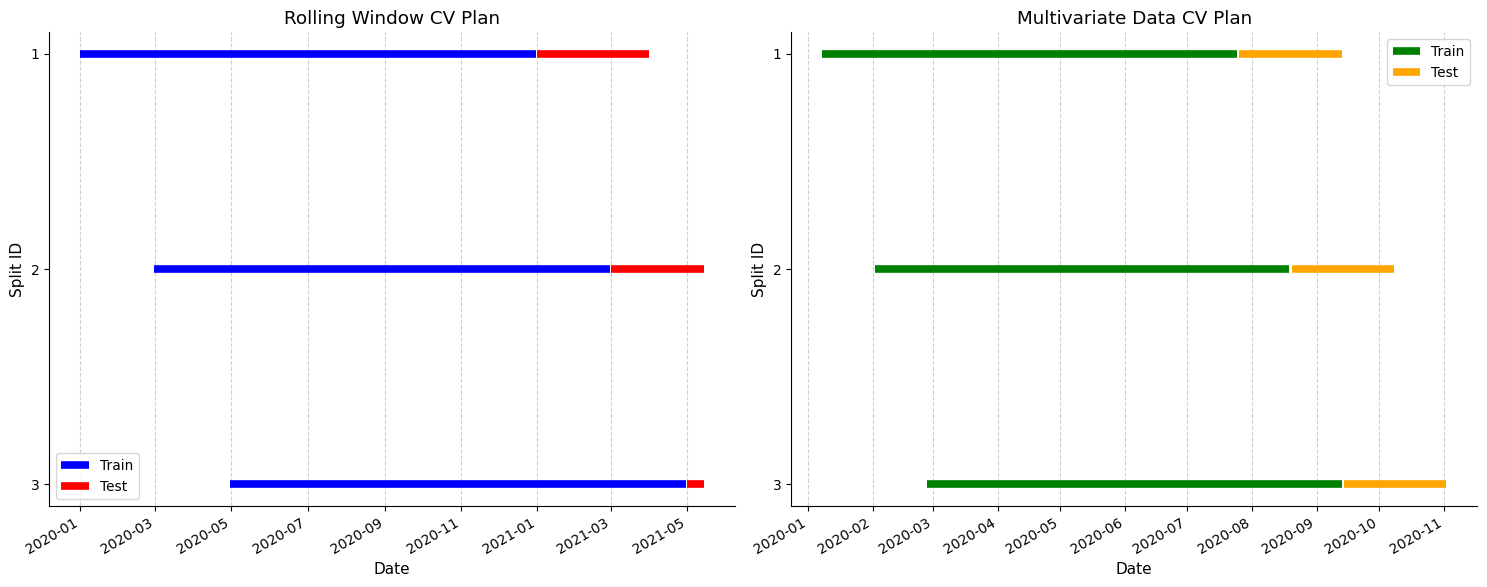

✅ CV plan visualizations completed!


In [5]:
# Visualize CV plans
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Rolling window plan
plot_time_series_cv_plan(
    data=ts_simple,
    splits=cv_splits_rolling,
    title="Rolling Window CV Plan",
    train_color='blue',
    test_color='red',
    ax=axes[0]
)

# DataFrame CV plan
plot_time_series_cv_plan(
    data=df_multivariate,
    splits=cv_splits_df,
    date_column='date',
    title="Multivariate Data CV Plan",
    train_color='green',
    test_color='orange',
    ax=axes[1]
)

plt.tight_layout()
plt.show()

print("✅ CV plan visualizations completed!")

## 5. Model Fitting and Evaluation {#model-fitting}

The `fit_resamples` function fits models to each CV split.

In [6]:
print("🔄 Demonstrating fit_resamples()")
print("=" * 35)

# Create models
linear_model = LinearRegression()
ridge_model = Ridge(alpha=1.0)
rf_model = RandomForestRegressor(n_estimators=50, random_state=42)

# Example 1: Univariate model
print("\n1️⃣ Univariate model fitting:")
results_univariate = fit_resamples(
    cv_splits=cv_splits_rolling[:3],
    model_spec=linear_model,
    data=ts_simple,
    target_column='value',
    feature_columns=None,
    model_id="linear_univariate"
)

print(f"   Results shape: {results_univariate.shape}")
print(f"   Unique slices: {results_univariate.index.get_level_values('slice_id').unique().tolist()}")
print(f"   Period types: {results_univariate['period_type'].unique().tolist()}")

# Example 2: Multivariate model
print("\n2️⃣ Multivariate model fitting:")
feature_columns = ['temperature', 'humidity', 'day_of_week', 'month', 'is_weekend']
results_multivariate = fit_resamples(
    cv_splits=cv_splits_df,
    model_spec=ridge_model,
    data=df_multivariate,
    target_column='sales',
    feature_columns=feature_columns,
    date_column='date',
    model_id="ridge_multivariate"
)

print(f"   Results shape: {results_multivariate.shape}")
print(f"   Features used: {feature_columns}")

# Example 3: Multiple models
print("\n3️⃣ Random Forest model:")
results_rf = fit_resamples(
    cv_splits=cv_splits_df[:2],
    model_spec=rf_model,
    data=df_multivariate,
    target_column='sales',
    feature_columns=feature_columns,
    date_column='date',
    model_id="random_forest"
)

print(f"   Results shape: {results_rf.shape}")

# Combine results
all_results = pd.concat([results_multivariate, results_rf], axis=0)
print(f"\n📊 Combined results shape: {all_results.shape}")
print(f"   Models: {all_results.index.get_level_values('model_id').unique().tolist()}")

print("\n✅ fit_resamples() examples completed!")

🔄 Demonstrating fit_resamples()

1️⃣ Univariate model fitting:
   Results shape: (1277, 9)
   Unique slices: [0, 1, 2]
   Period types: ['train', 'test']

2️⃣ Multivariate model fitting:
   Results shape: (750, 9)
   Features used: ['temperature', 'humidity', 'day_of_week', 'month', 'is_weekend']

3️⃣ Random Forest model:
   Results shape: (500, 9)

📊 Combined results shape: (1250, 9)
   Models: ['ridge_multivariate', 'random_forest']

✅ fit_resamples() examples completed!


## 6. Accuracy Metrics and Analysis {#accuracy-metrics}

Calculate performance metrics for model evaluation.

In [7]:
print("🔄 Demonstrating resample_accuracy()")
print("=" * 38)

# Example 1: Default metrics
print("\n1️⃣ Default metrics calculation:")
accuracy_default = resample_accuracy(results_multivariate)

print(f"   Results shape: {accuracy_default.shape}")
print(f"   Metrics: {accuracy_default['metric_name'].unique().tolist()}")
print("\n📊 Default Accuracy Results:")
print(accuracy_default.head())

# Example 2: Custom metrics
print("\n2️⃣ Custom metrics calculation:")

def safe_mape(y_true, y_pred):
    """MAPE with protection against division by zero."""
    return np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-8, None))) * 100

custom_metrics = {
    'mae': lambda y_true, y_pred: np.mean(np.abs(y_true - y_pred)),
    'rmse': lambda y_true, y_pred: np.sqrt(np.mean((y_true - y_pred) ** 2)),
    'mape': safe_mape,
    'r2': lambda y_true, y_pred: 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)
}

accuracy_custom = resample_accuracy(
    results_multivariate,
    metrics_set=custom_metrics
)

print(f"   Custom metrics: {accuracy_custom['metric_name'].unique().tolist()}")

# Example 3: Multiple models comparison
print("\n3️⃣ Multiple models accuracy:")
accuracy_all_models = resample_accuracy(all_results)

print(f"   Models compared: {accuracy_all_models['model_id'].unique().tolist()}")

# Summary statistics
print("\n📈 Summary by Model (RMSE):")
rmse_summary = accuracy_all_models[
    (accuracy_all_models['metric_name'] == 'rmse') & 
    (accuracy_all_models['period_type'] == 'test')
].groupby('model_id')['metric_value'].agg(['mean', 'std'])

print(rmse_summary.round(4))

print("\n✅ resample_accuracy() examples completed!")

🔄 Demonstrating resample_accuracy()

1️⃣ Default metrics calculation:
   Results shape: (6, 5)
   Metrics: ['mae', 'rmse']

📊 Default Accuracy Results:
   slice_id            model_id period_type metric_name  metric_value
0         0  ridge_multivariate        test         mae      2.593585
1         0  ridge_multivariate        test        rmse      3.162087
2         1  ridge_multivariate        test         mae      2.494204
3         1  ridge_multivariate        test        rmse      2.992522
4         2  ridge_multivariate        test         mae      2.514612

2️⃣ Custom metrics calculation:
   Custom metrics: ['mae', 'rmse', 'mape', 'r2']

3️⃣ Multiple models accuracy:
   Models compared: ['ridge_multivariate', 'random_forest']

📈 Summary by Model (RMSE):
                      mean     std
model_id                          
random_forest       6.0455  0.6515
ridge_multivariate  3.1044  0.0969

✅ resample_accuracy() examples completed!


## 7. Visualization and Plotting {#visualization}

Create visualizations to understand model performance.

🔄 Demonstrating plot_resamples()

1️⃣ Matplotlib plotting:


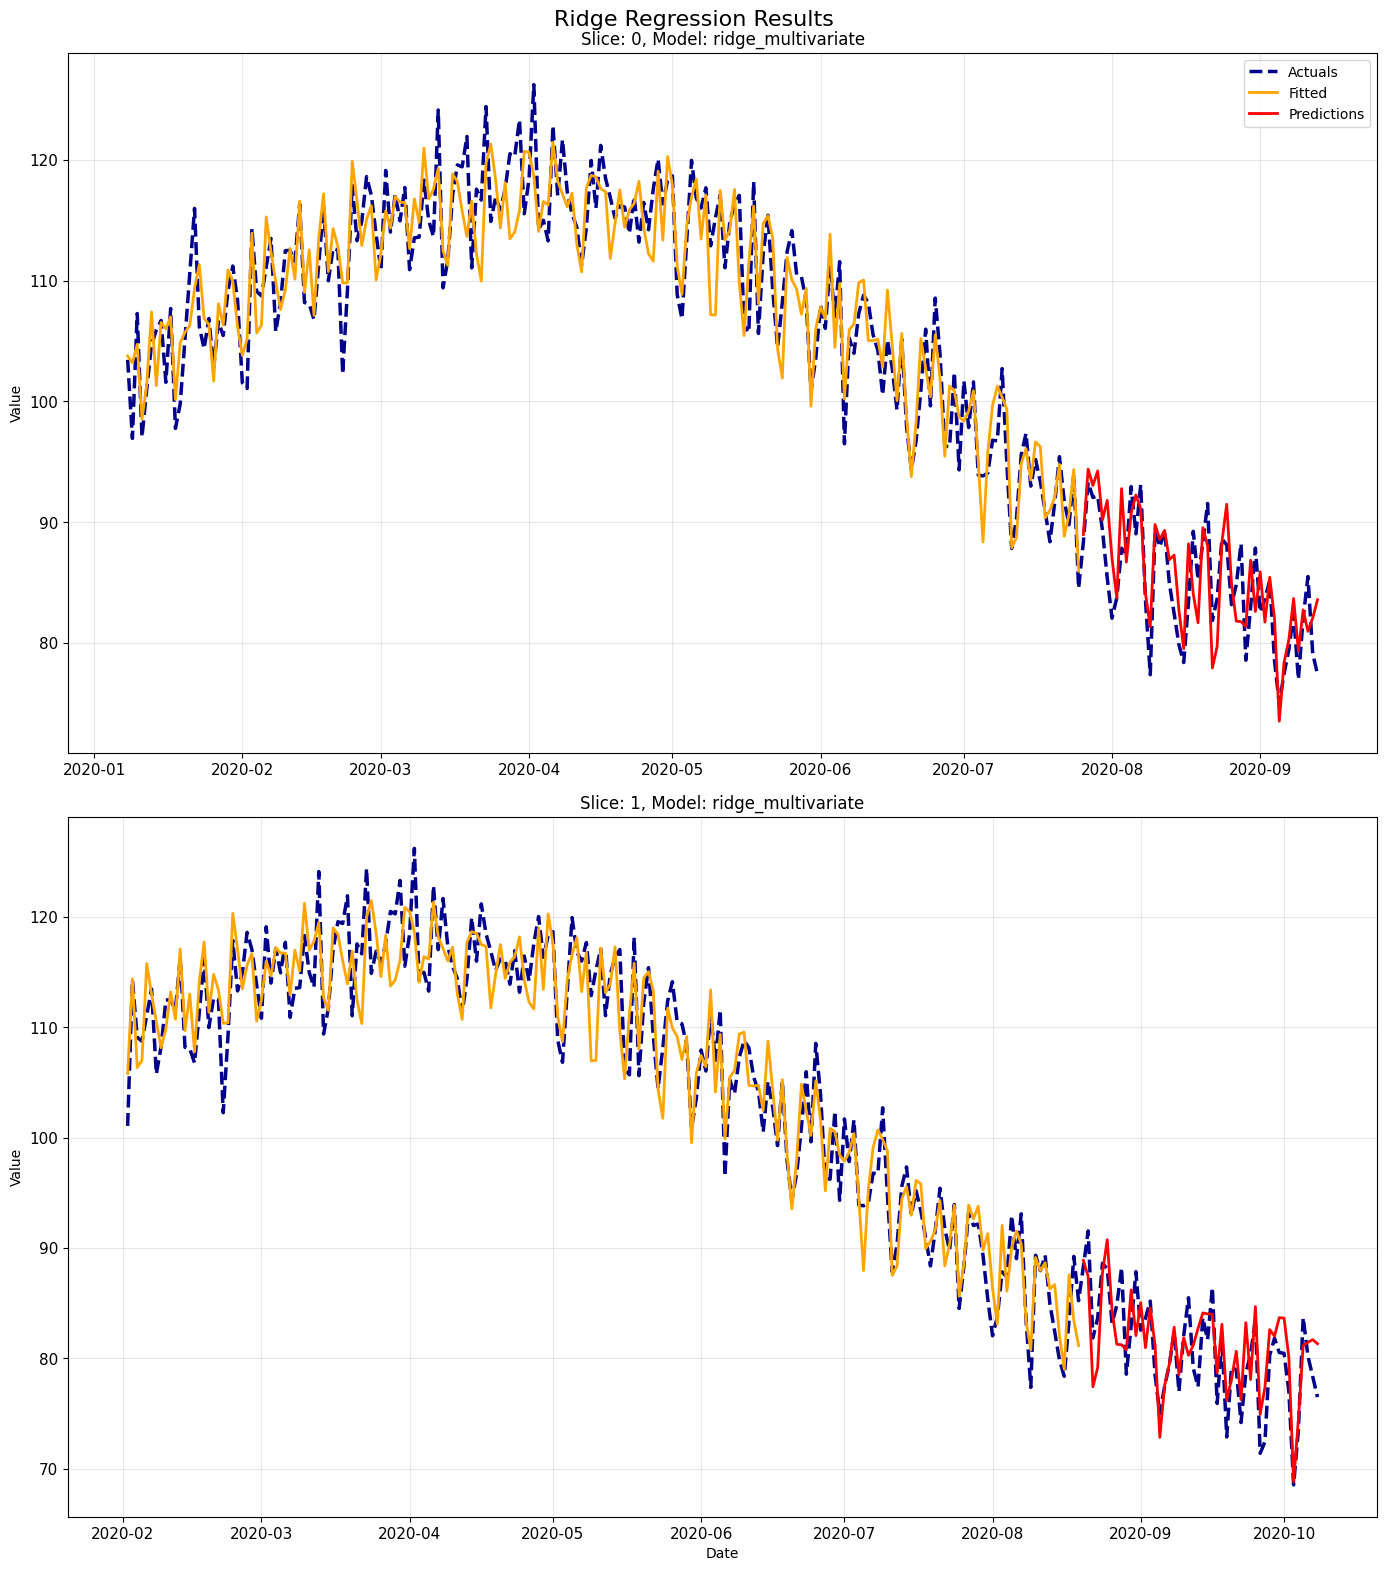

   ✅ Matplotlib plot completed

2️⃣ Multiple models comparison:


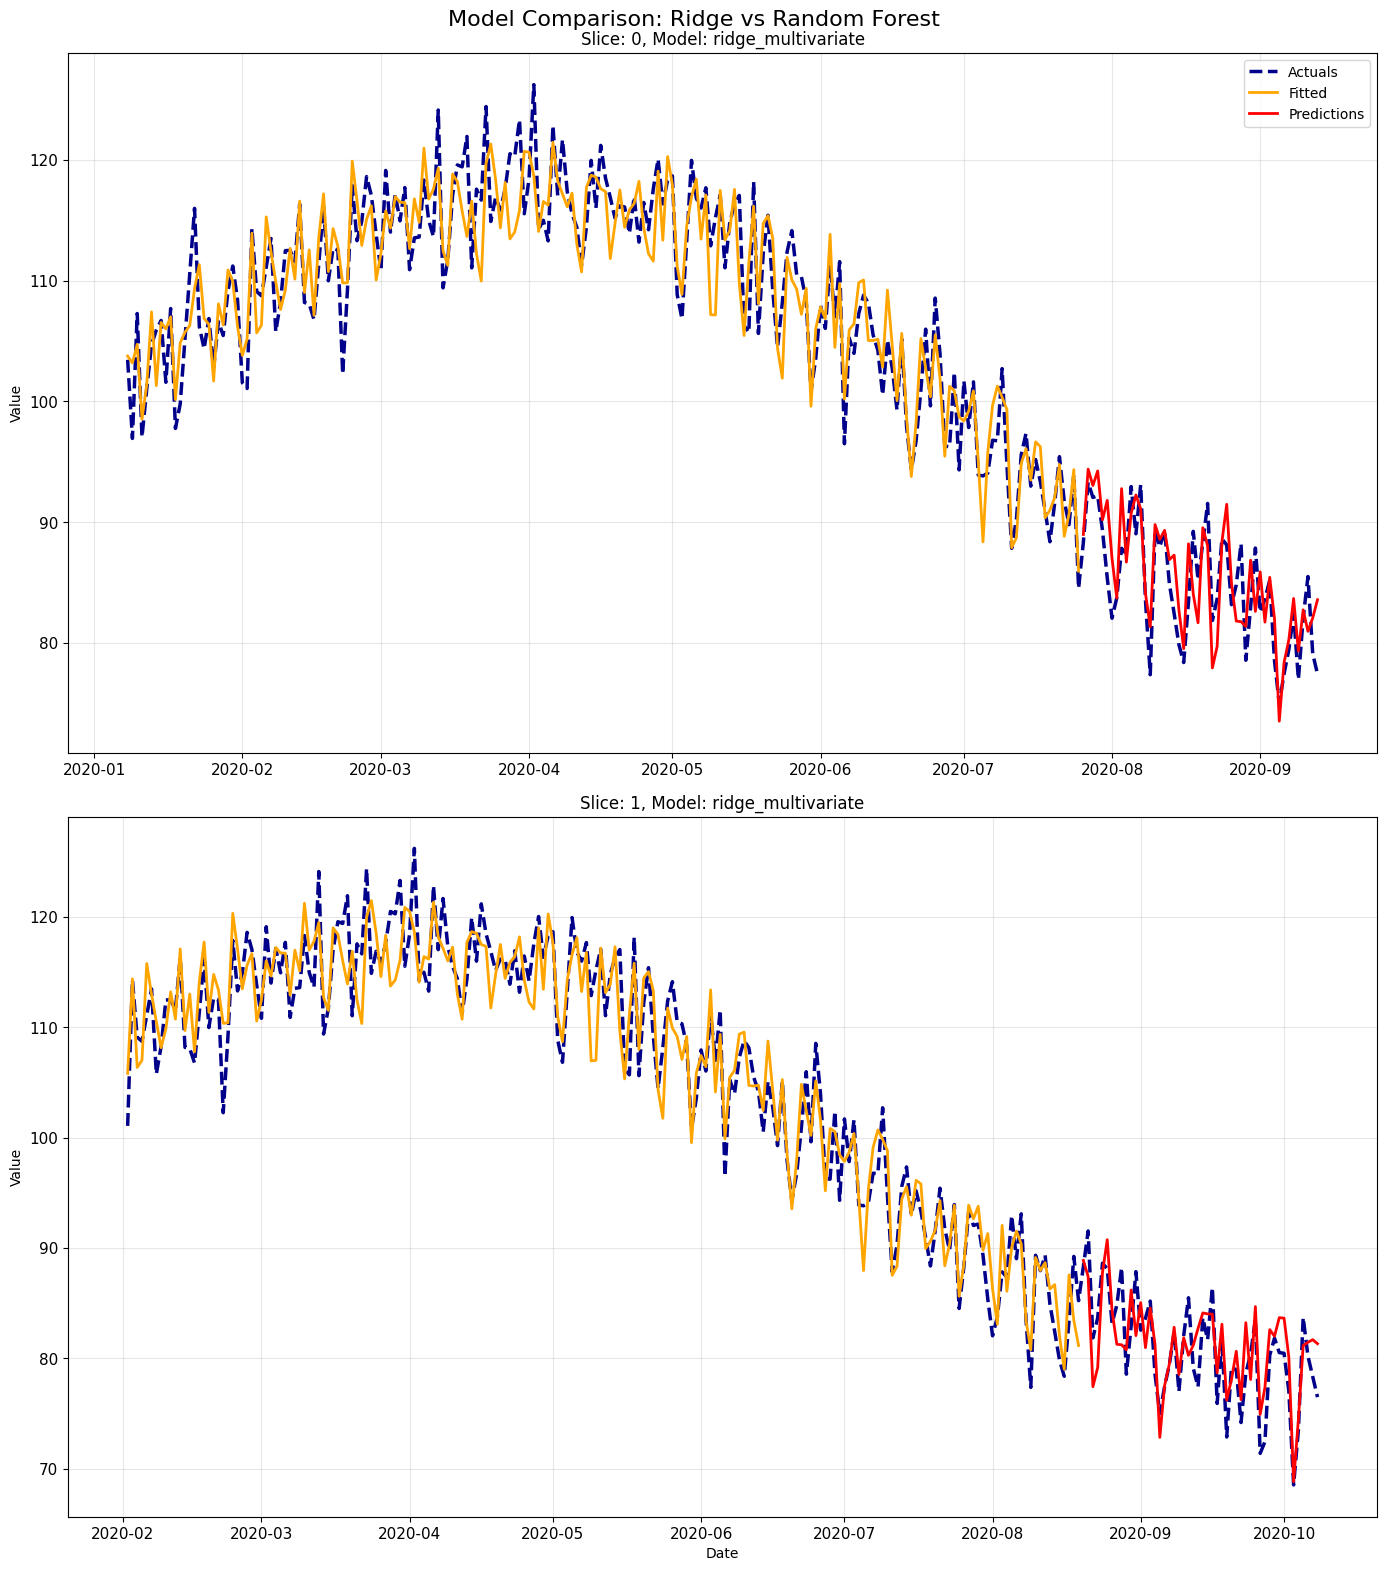

   ✅ Model comparison plot completed

✅ Visualization examples completed!


In [8]:
print("🔄 Demonstrating plot_resamples()")
print("=" * 36)

# Example 1: Matplotlib plotting
print("\n1️⃣ Matplotlib plotting:")
fig_mpl = plot_resamples(
    resamples_df=results_multivariate,
    max_splits_to_plot=2,
    title="Ridge Regression Results",
    engine='matplotlib',
    actual_color='darkblue',
    fitted_color='orange',
    prediction_color='red',
    figure_size=(14, 8)
)
plt.show()
print("   ✅ Matplotlib plot completed")

# Example 2: Multiple models comparison
print("\n2️⃣ Multiple models comparison:")
fig_comparison = plot_resamples(
    resamples_df=all_results,
    max_splits_to_plot=2,
    title="Model Comparison: Ridge vs Random Forest",
    engine='matplotlib',
    figure_size=(14, 8)
)
plt.show()
print("   ✅ Model comparison plot completed")

print("\n✅ Visualization examples completed!")

## 8. Convenience Functions {#convenience-functions}

High-level functions for common workflows.

In [9]:
print("🔄 Demonstrating Convenience Functions")
print("=" * 40)

# Example 1: evaluate_model
print("\n1️⃣ Quick model evaluation:")
quick_results = evaluate_model(
    data=df_multivariate,
    model=Ridge(alpha=0.5),
    initial='9 months',
    assess='2 months',
    skip='1 month',
    target_column='sales',
    feature_columns=['temperature', 'humidity', 'day_of_week'],
    date_column='date',
    slice_limit=3
)

print(f"   Results shape: {quick_results.shape}")
print(f"   Metrics: {quick_results['metric_name'].unique().tolist()}")

# Example 2: compare_models
print("\n2️⃣ Multi-model comparison:")
models_to_compare = {
    'linear': LinearRegression(),
    'ridge': Ridge(alpha=1.0),
    'forest': RandomForestRegressor(n_estimators=30, random_state=42)
}

comparison_results = compare_models(
    data=df_multivariate,
    models=models_to_compare,
    initial='8 months',
    assess='1 month',
    target_column='sales',
    feature_columns=['temperature', 'humidity', 'is_weekend'],
    date_column='date',
    slice_limit=3
)

print(f"   Models compared: {comparison_results['model_id'].unique().tolist()}")

# Summary
rmse_summary = comparison_results[
    comparison_results['metric_name'] == 'rmse'
].groupby('model_id')['metric_value'].mean()

best_model = rmse_summary.idxmin()
print(f"\n🥇 Best model: {best_model} (RMSE: {rmse_summary.min():.3f})")

# Example 3: Quick split
if QUICK_CV_AVAILABLE:
    print("\n3️⃣ Quick CV split:")
    try:
        X_train_q, X_test_q, y_train_q, y_test_q, _, _ = quick_cv_split(
            data=df_multivariate,
            test_size=50,
            date_column='date',
            target_column='sales',
            feature_columns=['temperature', 'humidity']
        )
        print(f"   Quick split: train={len(X_train_q)}, test={len(X_test_q)}")
        
        # Quick model fit
        model = LinearRegression()
        model.fit(X_train_q, y_train_q.values.ravel())
        predictions = model.predict(X_test_q)
        mae = mean_absolute_error(y_test_q.values.ravel(), predictions)
        print(f"   Quick model MAE: {mae:.2f}")
        
    except Exception as e:
        print(f"   ⚠️ Quick split failed: {e}")

print("\n✅ Convenience functions completed!")

🔄 Demonstrating Convenience Functions

1️⃣ Quick model evaluation:
   Results shape: (6, 5)
   Metrics: ['mae', 'rmse']

2️⃣ Multi-model comparison:
   Models compared: ['linear', 'ridge', 'forest']

🥇 Best model: ridge (RMSE: 3.207)

3️⃣ Quick CV split:
   Quick split: train=443, test=50
   Quick model MAE: 3.21

✅ Convenience functions completed!


## 9. Advanced Visualization {#advanced-visualization}

Advanced visualization tools for model comparison.

In [10]:
print("🔄 Advanced Visualization")
print("=" * 25)

if ADVANCED_VIZ_AVAILABLE:
    try:
        # Model comparison heatmap
        print("\n📊 Model Comparison Heatmap:")
        fig_heatmap = plot_model_comparison_matrix(
            accuracy_df=comparison_results,
            plot_type='heatmap',
            title="Model Performance Heatmap",
            engine='plotly'
        )
        fig_heatmap.show()
        print("   ✅ Heatmap created")
        
        # Comprehensive report
        print("\n📋 Comprehensive Report:")
        report = create_comparison_report(
            accuracy_df=comparison_results,
            title="Model Comparison Report"
        )
        print("   ✅ Report generated")
        print(f"   📈 Components: {list(report.keys())}")
        
        if 'rankings' in report:
            print("\n   🏆 Model Rankings:")
            print(report['rankings'].round(3))
            
    except Exception as e:
        print(f"   ⚠️ Advanced visualization failed: {e}")
else:
    print("   ⚠️ Advanced visualization not available")

print("\n✅ Advanced visualization completed!")

🔄 Advanced Visualization

📊 Model Comparison Heatmap:


   ✅ Heatmap created

📋 Comprehensive Report:
   ✅ Report generated
   📈 Components: ['figures', 'summary_stats', 'rankings', 'html']

   🏆 Model Rankings:
          mae_rank  rmse_rank  avg_rank
model_id                               
ridge          1.0        1.0       1.0
linear         2.0        2.0       2.0
forest         3.0        3.0       3.0

✅ Advanced visualization completed!


## 10. Interactive Dashboards {#interactive-dashboards}

Create interactive dashboards for exploring results.

In [11]:
print("🔄 Interactive Dashboard")
print("=" * 24)

if ADVANCED_VIZ_AVAILABLE:
    try:
        # Create interactive dashboard
        dashboard = create_interactive_dashboard(
            resamples_df=all_results,
            accuracy_df=comparison_results,
            title="ModelTime Resample Analysis Dashboard"
        )
        
        print("   ✅ Dashboard created successfully!")
        print("   📊 Features:")
        print("      - Real-time filtering")
        print("      - Interactive plots")
        print("      - Export capabilities")
        
        print("\n   💡 To launch dashboard:")
        print("      dashboard.run(port=8050)")
        print("      Then open http://localhost:8050")
        
    except Exception as e:
        print(f"   ⚠️ Dashboard creation failed: {e}")
        dashboard = None
else:
    print("   ⚠️ Interactive dashboard not available")
    dashboard = None

print("\n✅ Dashboard setup completed!")

🔄 Interactive Dashboard
   ✅ Dashboard created successfully!
   📊 Features:
      - Real-time filtering
      - Interactive plots
      - Export capabilities

   💡 To launch dashboard:
      dashboard.run(port=8050)
      Then open http://localhost:8050

✅ Dashboard setup completed!


## 11. Real-World Examples {#real-world-examples}

A realistic sales forecasting example.

In [12]:
print("🏪 Real-World Example: Sales Forecasting")
print("=" * 42)

# Create more realistic sales data
def create_sales_data(periods=1000):
    dates = pd.date_range('2020-01-01', periods=periods, freq='D')
    t = np.arange(periods)
    
    # Base sales with trend
    base_sales = 1000 + 0.1 * t
    
    # Seasonality
    yearly_season = 200 * np.sin(2 * np.pi * t / 365)
    weekly_season = 50 * np.sin(2 * np.pi * t / 7)
    
    # External factors
    temperature = 25 + 15 * np.sin(2 * np.pi * t / 365) + np.random.normal(0, 2, periods)
    marketing = np.random.lognormal(6, 0.3, periods)
    competition = np.random.binomial(1, 0.1, periods)
    
    # Calculate sales
    sales = (
        base_sales + yearly_season + weekly_season +
        0.8 * temperature + 0.01 * marketing - 100 * competition +
        np.random.normal(0, 30, periods)
    )
    
    return pd.DataFrame({
        'date': dates,
        'sales': np.maximum(sales, 0),
        'temperature': temperature,
        'marketing_spend': marketing,
        'competitor_promo': competition,
        'day_of_week': dates.dayofweek,
        'month': dates.month,
        'is_weekend': (dates.dayofweek >= 5).astype(int)
    })

# Create sales dataset
sales_data = create_sales_data()
print(f"\n📊 Sales dataset: {len(sales_data)} observations")
print(f"   Date range: {sales_data['date'].min()} to {sales_data['date'].max()}")
print(f"   Sales range: ${sales_data['sales'].min():.0f} - ${sales_data['sales'].max():.0f}")

# Define models for sales forecasting
sales_models = {
    'linear': LinearRegression(),
    'ridge': Ridge(alpha=1.0),
    'forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

# Feature sets
basic_features = ['day_of_week', 'month', 'is_weekend']
advanced_features = basic_features + ['temperature', 'marketing_spend', 'competitor_promo']

print(f"\n🤖 Testing with features: {advanced_features}")

# Compare models
sales_results = compare_models(
    data=sales_data,
    models=sales_models,
    initial='18 months',
    assess='3 months',
    skip='2 months',
    target_column='sales',
    feature_columns=advanced_features,
    date_column='date',
    slice_limit=3
)

print(f"\n📊 Sales forecasting results: {len(sales_results)} evaluations")

# Analysis
print("\n🏆 SALES FORECASTING ANALYSIS:")
for metric in ['mae', 'rmse']:
    metric_summary = sales_results[
        sales_results['metric_name'] == metric
    ].groupby('model_id')['metric_value'].mean()
    
    best_model = metric_summary.idxmin()
    best_value = metric_summary.min()
    
    print(f"   Best {metric.upper()}: {best_model} ({best_value:.2f})")

print("\n✅ Sales forecasting example completed!")

🏪 Real-World Example: Sales Forecasting

📊 Sales dataset: 1000 observations
   Date range: 2020-01-01 00:00:00 to 2022-09-26 00:00:00
   Sales range: $682 - $1442

🤖 Testing with features: ['day_of_week', 'month', 'is_weekend', 'temperature', 'marketing_spend', 'competitor_promo']

📊 Sales forecasting results: 18 evaluations

🏆 SALES FORECASTING ANALYSIS:
   Best MAE: forest (45.91)
   Best RMSE: forest (55.71)

✅ Sales forecasting example completed!


## 12. Best Practices {#best-practices}

Tips and guidelines for effective time series modeling.

In [13]:
print("📋 Best Practices for Time Series Modeling")
print("=" * 45)

best_practices = {
    "Data Preparation": [
        "• Ensure date columns are properly formatted",
        "• Handle missing values appropriately",
        "• Sort data chronologically",
        "• Check for outliers and anomalies",
        "• Consider data frequency in CV parameters"
    ],
    
    "Cross-Validation Strategy": [
        "• Choose initial size for stable model training",
        "• Set assess period to match forecasting horizon",
        "• Use skip to control training set overlap",
        "• Consider expanding windows for non-stationary data",
        "• Balance computation time with robustness"
    ],
    
    "Model Selection": [
        "• Start simple, then increase complexity",
        "• Use regularization to prevent overfitting",
        "• Compare against naive baselines",
        "• Consider ensemble methods",
        "• Validate on out-of-sample data"
    ],
    
    "Feature Engineering": [
        "• Include calendar features (seasonality)",
        "• Create lag features matching data patterns",
        "• Use rolling statistics for trends",
        "• Consider external factors",
        "• Avoid look-ahead bias"
    ],
    
    "Evaluation": [
        "• Use multiple metrics (MAE, RMSE, MAPE)",
        "• Focus on test set performance",
        "• Analyze residuals for patterns",
        "• Consider business-specific constraints",
        "• Document assumptions and limitations"
    ]
}

for category, practices in best_practices.items():
    print(f"\n🎯 {category}:")
    for practice in practices:
        print(f"  {practice}")

print("\n" + "=" * 60)
print("📈 MODELTIME RESAMPLE PY CAPABILITIES")
print("=" * 60)

capabilities = [
    "✅ Flexible time series splitting",
    "✅ Robust cross-validation strategies",
    "✅ Comprehensive model evaluation",
    "✅ Rich visualization options",
    "✅ Convenient workflow functions",
    "✅ Multi-model comparison tools",
    "✅ Interactive dashboards",
    "✅ Production-ready patterns"
]

for capability in capabilities:
    print(f"   {capability}")

print("\n🎯 This cookbook demonstrates the complete library functionality!")
print("🚀 Ready for production time series modeling workflows!")

📋 Best Practices for Time Series Modeling

🎯 Data Preparation:
  • Ensure date columns are properly formatted
  • Handle missing values appropriately
  • Sort data chronologically
  • Check for outliers and anomalies
  • Consider data frequency in CV parameters

🎯 Cross-Validation Strategy:
  • Choose initial size for stable model training
  • Set assess period to match forecasting horizon
  • Use skip to control training set overlap
  • Consider expanding windows for non-stationary data
  • Balance computation time with robustness

🎯 Model Selection:
  • Start simple, then increase complexity
  • Use regularization to prevent overfitting
  • Compare against naive baselines
  • Consider ensemble methods
  • Validate on out-of-sample data

🎯 Feature Engineering:
  • Include calendar features (seasonality)
  • Create lag features matching data patterns
  • Use rolling statistics for trends
  • Consider external factors
  • Avoid look-ahead bias

🎯 Evaluation:
  • Use multiple metrics (MA

---

## Conclusion

This comprehensive cookbook has demonstrated all the key features of `modeltime_resample_py`:

- ✅ **Time series splitting** with the new flexible API
- ✅ **Cross-validation strategies** for robust model evaluation
- ✅ **Model fitting and comparison** across multiple algorithms
- ✅ **Comprehensive metrics** for thorough analysis
- ✅ **Rich visualizations** for insights and communication
- ✅ **Convenience functions** for streamlined workflows
- ✅ **Real-world examples** with practical applications
- ✅ **Best practices** for effective modeling

The library provides a complete toolkit for time series model evaluation, from simple backtesting to advanced multi-model comparisons with interactive visualization.

### Next Steps

1. **Explore your own data** - Apply these patterns to your datasets
2. **Customize parameters** - Adjust CV strategies for your use case
3. **Try different models** - Experiment with various algorithms
4. **Create dashboards** - Build interactive tools for stakeholders
5. **Share insights** - Use visualizations to communicate findings

For more information:
- [Documentation](https://github.com/modeltime-contributors/py-modeltime-resample)
- [GitHub Repository](https://github.com/modeltime-contributors/py-modeltime-resample)
- [Getting Started Guide](../docs/getting_started.md)

Happy modeling! 🚀